In [1]:
import sys
sys.path.append('../..')
import numpy as np
import pandas as pd
from pathlib import Path
from model_utils import split_samples, split_periods
from plots import plot_timeseries
from neuralhydrology.utils.config import Config
import xarray as xr
from tqdm.auto import tqdm
import pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Configuración

In [4]:
TRAIN_SIZE = .7
VAL_SIZE = .3

In [5]:
# cargar archivo de configuración
config_file = Path('config_V_lstm64_fc32_do03.yml')
cfg = Config(config_file)

target = cfg.target_variables[0]

print(cfg.experiment_name)
print('epochs:', cfg.epochs, sep='\t\t')
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

V_lstm64_fc32_do03
epochs:		50
hidden size:	64
batch size:	128
dropout:	0.5
clip gradients:	1


## Samples 

In [6]:
# load attribute table
attrs = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_combined.csv', index_col='reservoir_id')
print('Reservoirs in the original attribute table:\t{0}'.format(attrs.shape[0]))

# load reservoir use table
use = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_use.csv', index_col='reservoir_id')
print('Reservoirs in the original use table:\t\t{0}'.format(use.shape[0]))

# select single-use, hydropower reservoirs
single_use = use.sum(axis=1) == 1
hydropower = use.hydropower == 1
attrs_sel = attrs.loc[hydropower & single_use]
print('Single-use hydopower reservoirs:\t\t{0}'.format(attrs_sel.shape[0]))

# divide sample in calibration, validation and test subsets
path = cfg.train_basin_file.parent
path.mkdir(exist_ok=True)
samples = split_samples(attrs_sel.index.tolist(), cal=TRAIN_SIZE, val=VAL_SIZE, seed=0)#, path=path)

# export or put out
if path is not None:
    for key, ls in samples.items():
        with open(path / f'sample_{key}.txt', 'w') as file:
            file.writelines(f"{id}\n" for id in ls)

Reservoirs in the original attribute table:	290
Reservoirs in the original use table:		290
Single-use hydopower reservoirs:		28


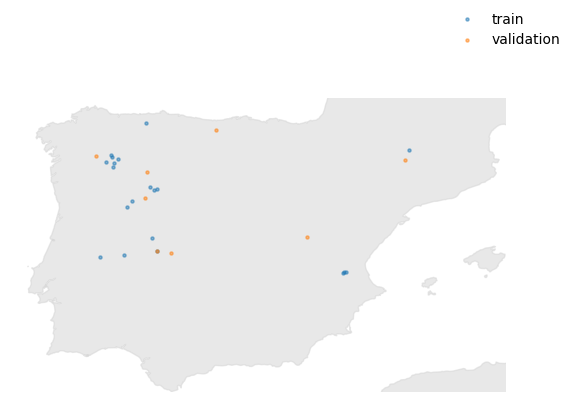

In [7]:
# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
for sample, ids in samples.items():
    ax.scatter(attrs_sel.loc[ids, 'LON'], attrs_sel.loc[ids, 'LAT'], s=5, alpha=.5, label=sample)
ax.set_aspect('equal')
ax.set_extent([-10, 3.5, 36, 44])
fig.legend(frameon=False)
ax.axis('off');

## Time series

### Load

In [8]:
# load timeseries
path_ts = cfg.data_dir / 'time_series'
timeseries = {}
for ID in tqdm(attrs_sel.index):
    file = path_ts / f'{ID}.nc'
    if file.is_file():
        timeseries[ID] = xr.open_dataset(file).to_pandas()#[cfg.target_variables].to_pandas()
    else:
        print(f'{file} was not found')

  0%|          | 0/28 [00:00<?, ?it/s]

### Periods 

In [13]:
# hard-code start of time series for reservoirs with errors
correct_start = {84: np.datetime64('1995-10-01', 'ns'),
                 2111: np.datetime64('1995-10-01', 'ns'),
                 2431: np.datetime64('1995-10-01', 'ns'),
                 2483: np.datetime64('1995-10-01', 'ns'),
                 593: np.datetime64('1995-10-01', 'ns')}

# define train, validation and test periods
periods = {}
for ID, df in timeseries.items():
    if ID in samples['train']:
        period = 'train'
        da = split_periods(df, cal=1, val=0)
    elif ID in samples['validation']:
        period = 'validation'
        da = split_periods(df, cal=0, val=1)
    if ID in correct_start:
        da.loc[{'date': 'start', 'period': period}] = correct_start[ID]
    periods[ID] = da
periods_da = xr.concat([da.assign_coords(id=str(ID)) for ID, da in periods.items()], dim='id')

# make sure there's 1 year of data before the start date
cutoff_date = np.datetime64('1992-01-02', 'ns')
periods_da = periods_da.where(periods_da >= cutoff_date, other=cutoff_date)
del periods

# reorganize periods as a dictionary
periods_dct = {}
for period in periods_da.period.data:
    periods_dct[period] = {}
    for ID in periods_da.id.data:
        periods_dct[period][ID] = {}
        for date in periods_da.date.data:
            periods_dct[period][ID][f'{date}_dates'] = [pd.Timestamp(periods_da.sel(period=period, id=ID, date=date).to_numpy().item())]

# export as a Pickle
for period, dct in periods_dct.items():
    with open(f'./data/periods_{period}.pkl', 'wb') as file:
        pickle.dump(dct, file)

### Plot

In [11]:
# plot timeserie
path_plots = path_ts / 'plots'
path_plots.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(timeseries.items()):
    # find start and end dates
    for p in list(samples):
        if ID in samples[p]:
            period = p
    start = periods_dct[period][ID]['start_dates'][0]
    end = periods_dct[period][ID]['end_dates'][0]
    
    title = '{0} - {1}\nDOR = {2:.3f}  DOD = {3:.3f} m'.format(ID, *attrs.loc[ID, ['RES_NAME', 'DOR', 'DOD_M']])
    plot_timeseries(df.loc[start:end], 'volume', 'inflow_efas5', 'outflow', ylabel='fraction filled (-)', title=title,
                    save=path_plots / f'{ID}.jpg')

  0%|          | 0/28 [00:00<?, ?it/s]